In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
from pipeline import Pipeline
from statistics import mean, median 

In [2]:
os.chdir("../")

In [3]:
def load_image(path: str) -> np.ndarray:
    
    return cv2.imread(path)

def display_image(image: np.ndarray, figsize=(7,7)) -> None:
    
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
def detectAndCompute(
    image: np.ndarray,
    featureDetector: cv2.Feature2D,
    **kwargs
) -> Tuple[cv2.KeyPoint, np.ndarray]:
    
    return featureDetector.detectAndCompute(image, None)

def findGoodMatches(
    des1: np.ndarray, 
    des2: np.ndarray, 
    matcher: cv2.DescriptorMatcher, 
    threshold: float = 0.75, 
    KNN: bool = True
) -> Tuple[Tuple, Tuple]:
    
    if KNN:
        matches = matcher.knnMatch(des1, des2, k=2)
    else: matches = matcher.BFMatcher(des1, des2)
    return [[m] for m, n in matches if m.distance < threshold*n.distance]

def drawMatches(
    image1: np.ndarray,
    image2: np.ndarray,
    keypoints1: cv2.KeyPoint,
    keypoints2: cv2.KeyPoint,
    matches: Tuple[Tuple, Tuple]
) -> np.ndarray:
    
    return cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2,
                              matches, None)

In [4]:
black = load_image('img/ref_black.png')
blue = load_image('img/ref_blue.png')
red = load_image('img/ref_red.png')
refs = [black, blue, red]

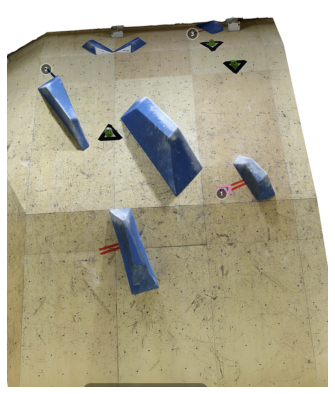

In [17]:
pov = cv2.imread("img/pov_blue_1.png")
display_image(pov)

Class 0: 22


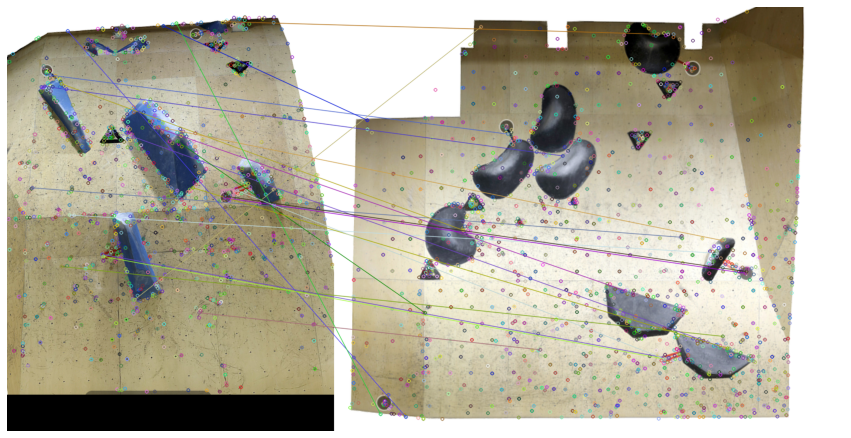

Class 1: 252


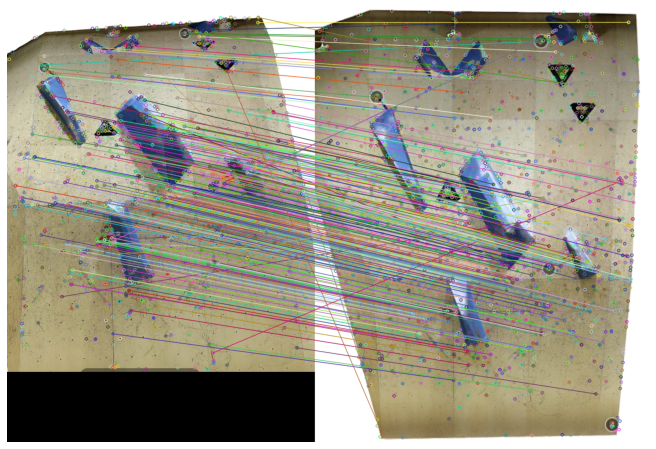

Class 2: 38


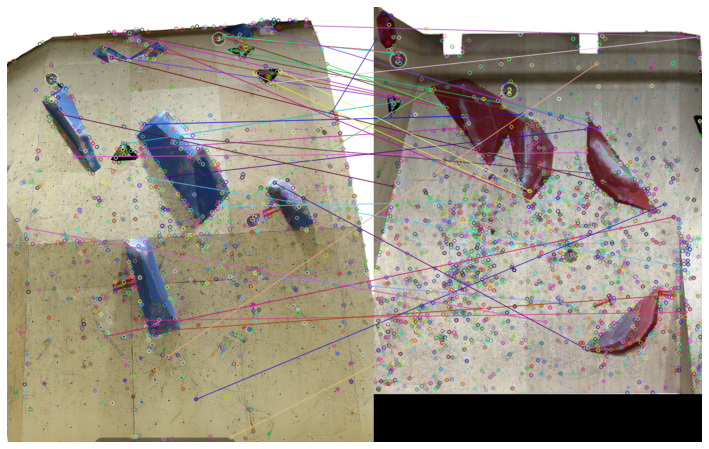

FINAL PROBS:
Class_0 : 7.051282051282051%
Class_1 : 80.76923076923077%
Class_2 : 12.179487179487179%


In [21]:
count = {}
for i, ref in enumerate(refs):
    sift = cv2.SIFT_create()
    kp1, des1 = detectAndCompute(pov, sift)
    kp2, des2 = detectAndCompute(ref, sift)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = findGoodMatches(des1, des2, flann)

    print(f'Class {i}: {len(matches)}')
    count[f'Class_{i}'] = len(matches)
    display_image(
        drawMatches(pov, ref, kp1, kp2, matches),
        figsize=(15, 8)
    )

print('FINAL PROBS:')
print(*(f'{key} : {val/sum(count.values())*100}%' for key,val in count.items()), sep='\n')

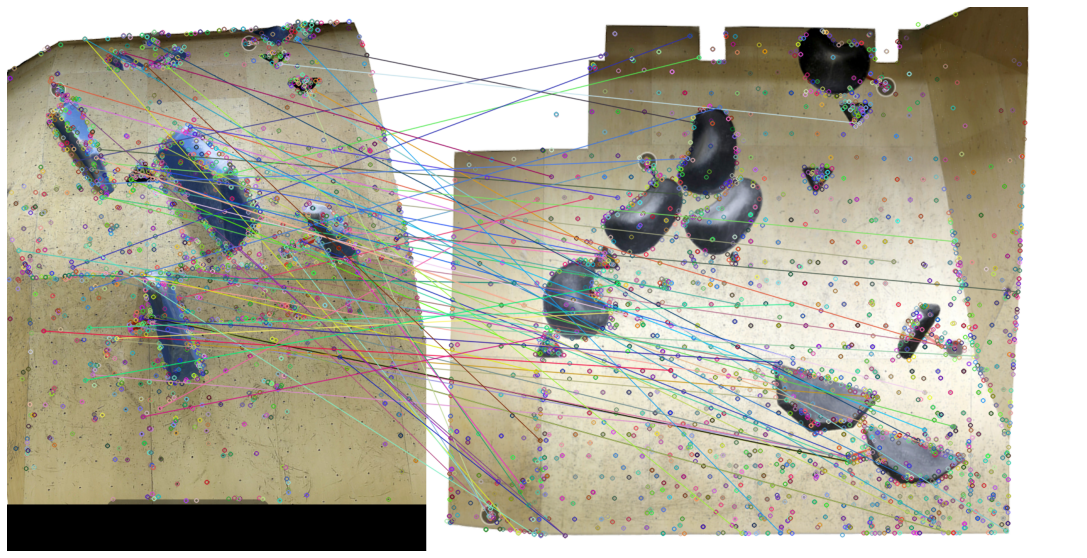

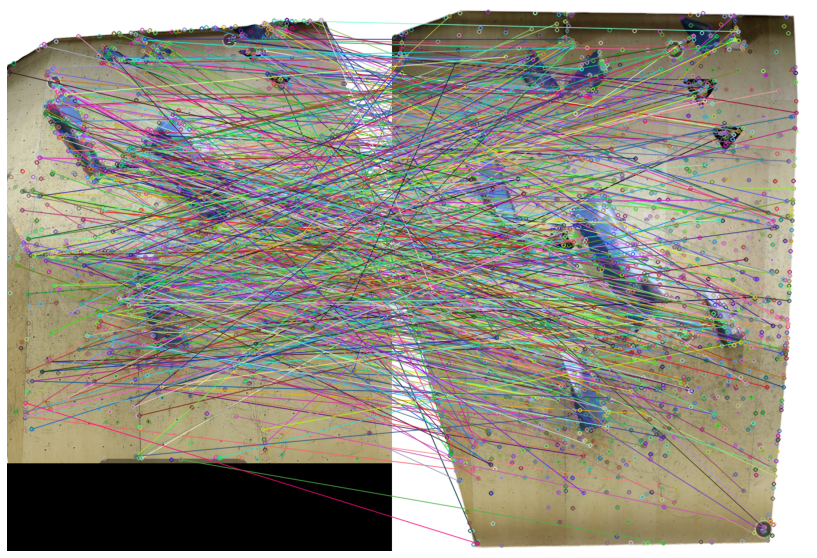

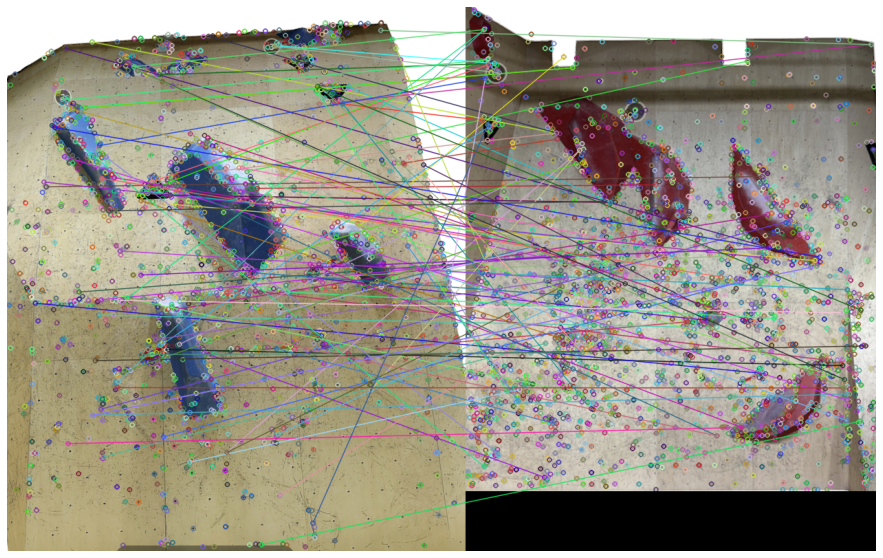

FINAL PROBS:
Class_0 : 5.379746835443038%
Class_1 : 81.64556962025317%
Class_2 : 12.974683544303797%


In [19]:
count = {}
for i, ref in enumerate(refs):
    acc = []
    matches = []
    kps1 = []
    kps2 = [] 
    for channel1, channel2 in zip(cv2.split(pov), cv2.split(ref)):
        sift = cv2.SIFT_create()
        kp1, des1 = detectAndCompute(channel1, sift)
        kp2, des2 = detectAndCompute(channel2, sift)
        kps1 += kp1
        kps2 += kp2

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params,search_params)

        match = findGoodMatches(des1, des2, flann)
        matches += match
    
    acc.append(len(match))
    display_image(
        drawMatches(pov, ref, kps1, kps2, matches),
        figsize=(20,10)
    )
    
    count[f'Class_{i}'] = mean(acc)

print('FINAL PROBS:')
print(*(f'{key} : {val/sum(count.values())*100}%' for key,val in count.items()), sep='\n')